**Name:** <span style="color:red">Maria Cobo and Alba Mas</span>

# SYSTEMS AND NETWORK BIOLOGY - PRACTICAL 6
# Stochastic description of protein expression

---

To submit your report, answer the questions below and save the *notebook* clicking on `File > Download as > iPython Notebook` in the menu at the top of the page. **Rename the notebook file** to ''`practicalN_name1_name2.ipynb`'', where `N` is the number of the practical, and `name1` and `name2` are the first surnames of the two team members (only one name if the report is sent individually). Finally, **submit the resulting file through the *Aul@-ESCI***.

Remember to label the axes in all the plots.

*IMPORTANT REMINDER: Before the final submission, remember to **reset the kernel** and re-run the whole notebook again to check that it works.*

---

Here we implement a stochastic description of simple protein expression processes, using a stochastic simulation algorithm know as the *next-reaction method*. We will consider a biochemical process constituted by $M$ reactions, denoted by $\mu=1,2,\ldots, M$, and $N$ biomolecular species, denoted by $i=1,2,\ldots,N$.

Let the rate of reaction $\mu$ be $k_\mu$, and their corresponding reactants $x_i^{(\mu)}$. The probability that this reaction occurs in the interval $(t,t+dt)$ given the state of the system at time $t$ is given by $a_\mu dt$, where $a_\mu$ is the *propensity* of the reaction. Following the law of mass action, and assuming that only one molecule of each reactant species is involved, the propensity of reaction $\mu$ has the form:

$$
a_\mu=k_\mu \prod_{i=1}^N x_i^{(\mu)}
$$

Another important piece of information that characterizes the reactions is the *stoichiometry matrix* $S_{\mu,i}$. The columns of this matrix are the reactions and the rows are the biomolecular species. The elements of the matrix represent how each reaction affect each species (e.g. a species that loses one molecule in a reaction has a value -1 in the corresponding matrix location, while if the reaction produces two molecules of a species, the corresponding matrix element is 2). Once the propensities and the stoichimetry matrix are known, the steps of the next-reaction stochastic simulation algorithm are:

1. Initialize the system (number of molecules and time)

2. Calculate the propensities of all reactions

3. Calculate the time $\tau$ at which the next reaction happens, using the expression:
$$
\tau=\frac{1}{a_{tot}}\ln\frac{1}{z_1}
$$
where $a_{tot}=\sum_{\nu=1}^Ma_\nu$ and $z_1$ is a random number uniformly distributed between 0 and 1.

4. Determine the reaction that occurs at time $\tau$ by calculating the smallest integer $\lambda$ such that
$$
\sum_{\nu=1}^\lambda a_\nu > z_2 \sum_{\nu=1}^Ma_\nu
$$
where $z_2$ is another random number uniformly distributed between 0 and 1.

5. Update the molecule numbers according to the stoichimetry coefficients $S_{\mu,i}$.

6. Go to step 2 to compute the next reaction.

Let us implement this algorithm for a simple birth-death process representing protein expression and degradation:
$$
\emptyset\overset{k_{exp}}{\rightarrow} A,\quad A\overset{k_{deg}}{\rightarrow}\emptyset
$$

First, we load all necessary `Python` packages.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import poisson

Next, we define the values of the parameters, the stoichimetry matrix and the initial conditions (step 1 above). We consider first that $k_{exp}=100$ and $k_{deg}=1$.

In [21]:
# Model parameters
k_exp = 100
k_deg = 1   

# Stoichiometry matrix
# Rows represent species (A), columns represent reactions
# Reaction 1 (birth): ∅ → A, Reaction 2 (death): A → ∅
S = np.array([[1, -1]])

# Initial conditions
A_initial = 0        
time_initial = 0.0   

Now we compute the propensities (step 2 above), calculate the next reaction time (step 3), and determine the reaction that takes place (step 4). For steps 3 and 4 use the function `uniform` from the module `numpy.random`.

In [22]:
def calculate_propensities(A):
    a_exp = k_exp
    a_deg = k_deg * A
    return np.array([a_exp, a_deg])

def compute_next_reaction(A):
    propensities = calculate_propensities(A)
    a_total = np.sum(propensities)
    if a_total == 0:
        return None, None, None
    z1 = np.random.uniform(0, 1)
    tau = (1 / a_total) * np.log(1 / z1)
    z2 = np.random.uniform(0, 1)
    cumulative_sum = np.cumsum(propensities)
    reaction_index = np.where(cumulative_sum > z2 * a_total)[0][0]
    return tau, reaction_index, propensities

Finally, we update the molecule numbers and the time variable (step 5 above).

In [23]:
def update_system(A, time, reaction_index, tau):
    A += S[0, reaction_index]
    time += tau
    return A, time


Now put together steps 2-5 above in a loop, and generate output every *mt* time units (you might need to save the same state of the system for multiple output times, if no reaction happens in a given *mt* interval). Run the simulation for 200 time units with sampling period $mt=0.1$.

In [24]:
def run_simulation(T_max, mt):
    A = A_initial
    time = time_initial
    next_output_time = mt
    times = []
    molecule_counts = []
    while time < T_max:
        tau, reaction_index, _ = compute_next_reaction(A)
        if reaction_index is None:
            break
        A, time = update_system(A, time, reaction_index, tau)
        while time >= next_output_time:
            times.append(next_output_time)
            molecule_counts.append(A)
            next_output_time += mt
    return np.array(times), np.array(molecule_counts)

# Generate simulation data
T_max = 200
mt = 0.1
times, molecule_counts = run_simulation(T_max, mt)

Now we plot the time series of molecule numbers, and the histogram of molecule number of all data during the second half of the simulation (stationary state). Normalize this histogram so that it has unit area, and compare it with the expression of the Poisson distribution derived in class.

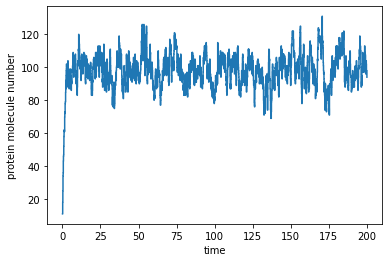

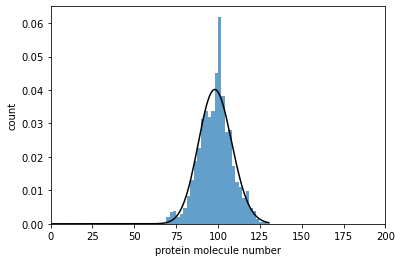

In [25]:
# Time Series Plot
plt.figure()
plt.step(times, molecule_counts, where='post', linewidth=1.5)
plt.xlabel('time')
plt.ylabel('protein molecule number')
plt.show()

# Plot histogram and Poisson distribution
steady_state_data = molecule_counts[times >= 100]
mean_count = np.mean(steady_state_data)

plt.figure()
hist, bins, _ = plt.hist(steady_state_data, bins=30, density=True, alpha=0.7)

poisson_dist = poisson.pmf(np.arange(0, bins[-1]), mean_count)
plt.plot(np.arange(0, bins[-1]), poisson_dist, 'k-', linewidth=1.5)

plt.xlabel('protein molecule number')
plt.ylabel('count')
plt.xlim(0, 200)
plt.show()


---

<span style="color:red">Comment your result here</span>

If we look at the time series plot we observe that the molecule count moves around a steady-state mean of approximately 100 with some variation due to the stochastic nature of the simulation.

When looking at the histogram we can confirm that these steady-state levels follow a Poisson distribution and the distribution is relatively narrow, indicating limited variability around the mean

These results confirm that the theoretical model of protein expression and degradation works, showing that the simulation accurately reflects the random processes.

---

Next, we separate the expression into transcription and translation. We thus have four reactions (transcription, translation, mRNA degradation and protein degradation) and two species (mRNA and protein). Integrate the system of reactions and plot the resulting time series and normalized histograms for the two species. Consider a transcription rate $k_{tx}=10$, a translation rate $k_{tl}=100$, and $k_{deg}=1$.

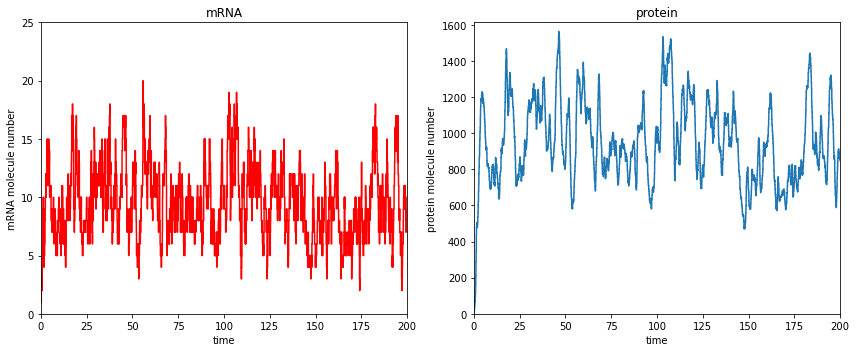

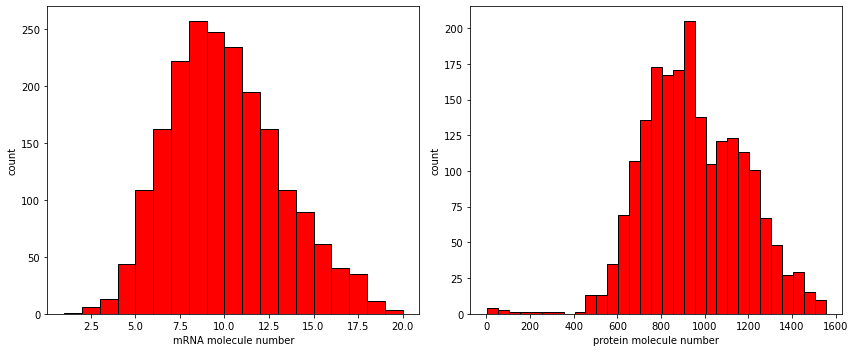

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Model parameters
k_txn = 10      # Transcription rate
k_tl = 100      # Translation rate
k_deg = 1       # Degradation rate

# Stoichiometry matrix
S = np.array([[1, 0, -1, 0],       # mRNA changes per reaction
              [0, 1,  0, -1]])     # Protein changes per reaction

# Initial conditions
mRNA_initial = 0
protein_initial = 0
time_initial = 0.0

# Define functions for the simulation
def calculate_propensities(mRNA, protein):
    a_txn = k_txn                    # Transcription propensity
    a_tl = k_tl * mRNA               # Translation propensity
    a_deg_mRNA = k_deg * mRNA        # mRNA degradation propensity
    a_deg_protein = k_deg * protein  # Protein degradation propensity
    return np.array([a_txn, a_tl, a_deg_mRNA, a_deg_protein])

def compute_next_reaction(mRNA, protein):
    propensities = calculate_propensities(mRNA, protein)
    a_total = np.sum(propensities)
    if a_total == 0:
        return None, None, None
    z1 = np.random.uniform(0, 1)
    tau = (1 / a_total) * np.log(1 / z1)
    z2 = np.random.uniform(0, 1)
    cumulative_sum = np.cumsum(propensities)
    reaction_index = np.where(cumulative_sum > z2 * a_total)[0][0]
    return tau, reaction_index, propensities

def update_system(mRNA, protein, time, reaction_index, tau):
    mRNA += S[0, reaction_index]
    protein += S[1, reaction_index]
    time += tau
    return mRNA, protein, time

# Main simulation function
def run_simulation(T_max, mt):
    mRNA = mRNA_initial
    protein = protein_initial
    time = time_initial
    next_output_time = mt
    times = []
    mRNA_counts = []
    protein_counts = []
    while time < T_max:
        tau, reaction_index, _ = compute_next_reaction(mRNA, protein)
        if reaction_index is None:
            break
        mRNA, protein, time = update_system(mRNA, protein, time, reaction_index, tau)
        while time >= next_output_time:
            times.append(next_output_time)
            mRNA_counts.append(mRNA)
            protein_counts.append(protein)
            next_output_time += mt
    return np.array(times), np.array(mRNA_counts), np.array(protein_counts)

# Simulation parameters
T_max = 200     # Total simulation time
mt = 0.1        # Time interval for data collection
times, mRNA_counts, protein_counts = run_simulation(T_max, mt)

# Plotting Time Series for mRNA and Protein
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.step(times, mRNA_counts, where='post', color='r', linewidth=1.5, label='mRNA')
plt.xlabel('time')
plt.ylabel('mRNA molecule number')
plt.title('mRNA')
plt.xlim(0, T_max)
plt.ylim(0, max(mRNA_counts) + 5)

plt.subplot(1, 2, 2)
plt.step(times, protein_counts, where='post', linewidth=1.5, label='Protein')
plt.xlabel('time')
plt.ylabel('protein molecule number')
plt.title('protein')
plt.xlim(0, T_max)
plt.ylim(0, max(protein_counts) + 50)
plt.tight_layout()
plt.show()

# Plotting Histograms for mRNA and Protein
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(mRNA_counts, bins=np.arange(min(mRNA_counts), max(mRNA_counts) + 1, 1), color='red', edgecolor='black')
plt.xlabel('mRNA molecule number')
plt.ylabel('count')

plt.subplot(1, 2, 2)
plt.hist(protein_counts, bins=np.arange(min(protein_counts), max(protein_counts) + 1, 50), color='red', edgecolor='black')
plt.xlabel('protein molecule number')
plt.ylabel('count')
plt.tight_layout()
plt.show()


---

<span style="color:red">Comment your result here</span>

On one hand, by looking at the time series plots we observe that the molecule count moves around a steady-state mean of approximately 10 molecules for mRNA and around 1000 molecules protein, with some variation due to the stochastic nature of the simulation. The randomness inherent in transcription, translation, and degradation creates variability around these mean levels. 

On the other hand, the histograms provide an insight into the distribution of mRNA and protein molecule counts over time. The mRNA histogram shows a peak arounf 10 molecules, indicating that the system most frequently mantains mRNA levels near the steady-state mean. The distribution is relatively narrow, showing a lower variability in mRNA levels. Moreover, the protein histogram shows a broader distribution around 1000 molecules and, shows a more variable distribution. This increased variability is a result of the high translation rate, which amplifies fluctuations in mRNA levels, and the slower degradation rate, which allows protein molecules to accumulate over time. 

---

Finally, scale the transcription and translation rates by the same factor, multiplying one of the rates and dividing the other, in such a way that the product remains constant, and discuss what happens with the mean and standard deviation of the distribution of protein numbers for different values of this factor (smaller and larger than 1).

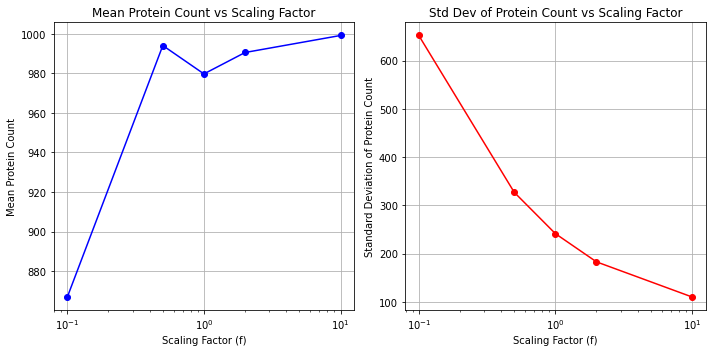

In [27]:
k_txn = 10      # Initial transcription rate
k_tl = 100      # Initial translation rate
k_deg = 1       # Degradation rate

# Stoichiometry matrix
S = np.array([[1, 0, -1, 0],       # mRNA changes per reaction
              [0, 1,  0, -1]])     # Protein changes per reaction

# Initial conditions
mRNA_initial = 0
protein_initial = 0
time_initial = 0.0

# Functions for the simulation
def calculate_propensities(mRNA, protein, k_txn, k_tl):
    a_txn = k_txn                    # Transcription propensity
    a_tl = k_tl * mRNA               # Translation propensity
    a_deg_mRNA = k_deg * mRNA        # mRNA degradation propensity
    a_deg_protein = k_deg * protein  # Protein degradation propensity
    return np.array([a_txn, a_tl, a_deg_mRNA, a_deg_protein])

def compute_next_reaction(mRNA, protein, k_txn, k_tl):
    propensities = calculate_propensities(mRNA, protein, k_txn, k_tl)
    a_total = np.sum(propensities)
    if a_total == 0:
        return None, None, None
    z1 = np.random.uniform(0, 1)
    tau = (1 / a_total) * np.log(1 / z1)
    z2 = np.random.uniform(0, 1)
    cumulative_sum = np.cumsum(propensities)
    reaction_index = np.where(cumulative_sum > z2 * a_total)[0][0]
    return tau, reaction_index, propensities

def update_system(mRNA, protein, time, reaction_index, tau):
    mRNA += S[0, reaction_index]
    protein += S[1, reaction_index]
    time += tau
    return mRNA, protein, time

# Main simulation function
def run_simulation(T_max, mt, k_txn, k_tl):
    mRNA = mRNA_initial
    protein = protein_initial
    time = time_initial
    next_output_time = mt
    protein_counts = []
    while time < T_max:
        tau, reaction_index, _ = compute_next_reaction(mRNA, protein, k_txn, k_tl)
        if reaction_index is None:
            break
        mRNA, protein, time = update_system(mRNA, protein, time, reaction_index, tau)
        while time >= next_output_time:
            protein_counts.append(protein)
            next_output_time += mt
    return np.array(protein_counts)

T_max = 200     # Total simulation time
mt = 0.1        # Time interval for data collection

# Run simulations for different scaling factors
scaling_factors = [0.1, 0.5, 1, 2, 10]  # Smaller and larger than 1
mean_protein_counts = []
std_protein_counts = []

for f in scaling_factors:
    k_txn_scaled = f * k_txn
    k_tl_scaled = k_tl / f
    protein_counts = run_simulation(T_max, mt, k_txn_scaled, k_tl_scaled)
    mean_protein_counts.append(np.mean(protein_counts))
    std_protein_counts.append(np.std(protein_counts))

# Plot the mean and standard deviation of protein counts for different factors
plt.figure(figsize=(10, 5))

# Mean protein count plot
plt.subplot(1, 2, 1)
plt.plot(scaling_factors, mean_protein_counts, marker='o', color='b', label='Mean')
plt.xlabel('Scaling Factor (f)')
plt.ylabel('Mean Protein Count')
plt.title('Mean Protein Count vs Scaling Factor')
plt.xscale('log')
plt.grid()

# Standard deviation of protein count plot
plt.subplot(1, 2, 2)
plt.plot(scaling_factors, std_protein_counts, marker='o', color='r', label='Standard Deviation')
plt.xlabel('Scaling Factor (f)')
plt.ylabel('Standard Deviation of Protein Count')
plt.title('Std Dev of Protein Count vs Scaling Factor')
plt.xscale('log')
plt.grid()

plt.tight_layout()
plt.show()


---

<span style="color:red">Comment your result here</span>


In this code, we applied different scaling factors to the transcription and translation rates, mantaining a constant product. For each value of f, we ran the simulation and recorded the protein counts at each time step. Then, after each simulation, we calculated the mean and standard deviation of the protein counts, and we stored them. Finally, we plotted the mean and standard deviation of the protein counts against the scaling factors. 

Therefore, in our results, for the mean protein count, we can see that there are minor variations, possibly due to the stochastic nature, but the mean protein count stays approximately the same across different values of f. 

Furthermore, the standard deviation of protein counts dicreases significantly as f increases. For values smaller than 1 (where transcription is low and translation is high), the standard deviation is the highest. As fewer molecules are produced but each has a high translation rate, the protein production is higher, increasing variability. And, for values bigger than 1 (where transcription is high and translation is low), the standard deviation is lower. In this case, smaller transcription events lead to a more stable protein count (more even over time), as each mRNA molecule produces less proteins. 

---